In [2]:
import os
import numpy as np
from glob import glob
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf

In [3]:
# Dossiers
base_path = "/kaggle/input/augmented-forest-segmentation/Forest Segmented/Forest Segmented"

images_dir = os.path.join(base_path, "images")
masks_dir = os.path.join(base_path, "masks")

# Lister et trier tous les fichiers .jpg
image_paths = sorted(glob(os.path.join(images_dir, "*.jpg")))
mask_paths = sorted(glob(os.path.join(masks_dir, "*.jpg")))

print(f"Nombre d'images : {len(image_paths)}")
print(f"Nombre de masques : {len(mask_paths)}")

Nombre d'images : 5108
Nombre de masques : 5108


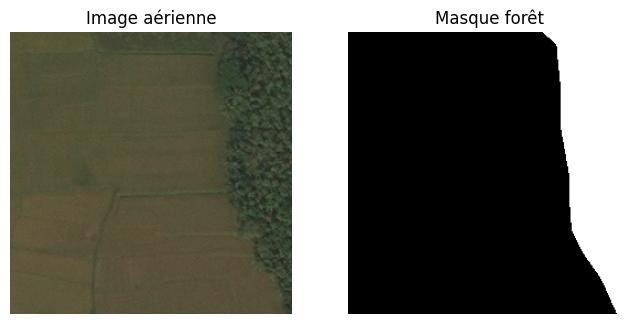

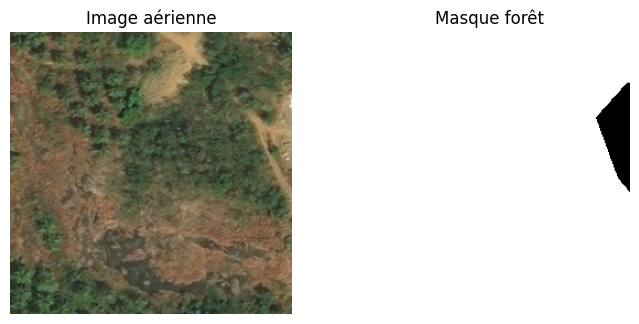

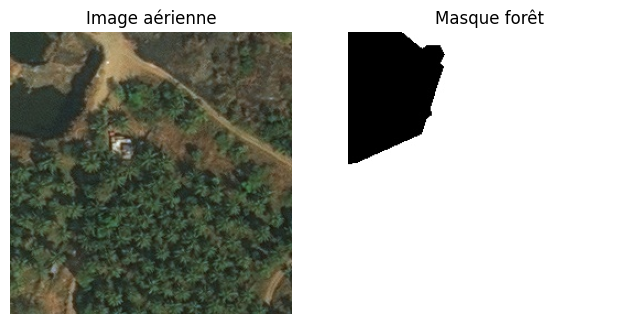

In [4]:
# Choisir 3 exemples aléatoires
for i in [0, 10, 20]:
    img = cv2.imread(image_paths[i])                 # Lire image (BGR)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)      # Convertir en RGB
    mask = cv2.imread(mask_paths[i], cv2.IMREAD_GRAYSCALE)  # Masque en niveaux de gris
    
    plt.figure(figsize=(8,4))
    plt.subplot(1,2,1)
    plt.imshow(img)
    plt.title("Image aérienne")
    plt.axis("off")
    
    plt.subplot(1,2,2)
    plt.imshow(mask, cmap="gray")
    plt.title("Masque forêt")
    plt.axis("off")
    
    plt.show()


In [5]:
def preprocess_image(img_path):
    img = cv2.imread(img_path)               
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img = img / 255.0                         
    return img

def preprocess_mask(mask_path, threshold=127):
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
    mask = np.where(mask > threshold, 1, 0)    
    mask = np.expand_dims(mask, axis=-1)      
    return mask

In [6]:

# 70% train
train_size = 0.7
# 20% val
val_size = 0.2 / (1 - train_size)  # proportion de la partie restante (30%)

# Split train / temp (train 70%, temp 30%)
train_img, temp_img, train_mask, temp_mask = train_test_split(
    image_paths, mask_paths, test_size=1-train_size, random_state=42
)

# Split temp en validation et test (20% et 10% du total)
val_img, test_img, val_mask, test_mask = train_test_split(
    temp_img, temp_mask, test_size=1-(val_size), random_state=42
)

print(f"Train: {len(train_img)} images")
print(f"Validation: {len(val_img)} images")
print(f"Test: {len(test_img)} images")

Train: 3575 images
Validation: 1021 images
Test: 512 images


In [7]:
from tensorflow.keras.utils import Sequence
import albumentations as A  # bibliothèque pour augmentation
import random

# --- Définir les augmentations ---
augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),         # Flip horizontal aléatoire
    A.VerticalFlip(p=0.5),           # Flip vertical aléatoire
    A.Rotate(limit=30, p=0.5),       # Rotation aléatoire jusqu'à ±30°
    A.RandomBrightnessContrast(p=0.3) # Ajustement de luminosité/contraste
])

class DataGenerator(Sequence):
    def __init__(self, image_paths, mask_paths, batch_size=16, shuffle=True, augment=False):
        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.augment = augment
        self.indexes = np.arange(len(self.image_paths))
        self.on_epoch_end()
    
    def __len__(self):
        return int(np.ceil(len(self.image_paths) / self.batch_size))
    
    def __getitem__(self, index):
        batch_indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_img_paths = [self.image_paths[i] for i in batch_indexes]
        batch_mask_paths = [self.mask_paths[i] for i in batch_indexes]
        
        X = []
        Y = []
        for img_path, mask_path in zip(batch_img_paths, batch_mask_paths):
            img = preprocess_image(img_path)
            mask = preprocess_mask(mask_path)
            
            # --- Data augmentation ---
            if self.augment:
                augmented = augmentation(image=img, mask=mask)
                img = augmented['image']
                mask = augmented['mask']
            
            X.append(img)
            Y.append(mask)
        
        return np.array(X, dtype=np.float32), np.array(Y, dtype=np.float32)
    
    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# --- Création des générateurs ---
batch_size = 16

train_gen = DataGenerator(train_img, train_mask, batch_size=batch_size, augment=True)
val_gen = DataGenerator(val_img, val_mask, batch_size=batch_size, augment=False)
test_gen = DataGenerator(test_img, test_mask, batch_size=batch_size, shuffle=False, augment=False)


In [8]:
X_batch, Y_batch = train_gen[0]
print("Shape X_batch :", X_batch.shape)
print("Shape Y_batch :", Y_batch.shape)

Shape X_batch : (16, 256, 256, 3)
Shape Y_batch : (16, 256, 256, 1)


In [24]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# --- Patch Embedding ---
class PatchEmbedding(layers.Layer):
    def __init__(self, patch_size=16, embed_dim=768, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
        self.embed_dim = embed_dim
        self.proj = layers.Conv2D(embed_dim, patch_size, strides=patch_size, padding='valid')
        self.flatten = layers.Reshape((-1, embed_dim))
    
    def call(self, x):
        x = self.proj(x)
        x = self.flatten(x)
        return x

# --- Transformer Block ---
def transformer_block(x, num_heads=12, mlp_dim=2048, dropout_rate=0.1):
    # Layer Norm
    x1 = layers.LayerNormalization(epsilon=1e-6)(x)
    # Multi-Head Self Attention
    attention_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=x.shape[-1])(x1, x1)
    attention_output = layers.Dropout(dropout_rate)(attention_output)
    x2 = layers.Add()([x, attention_output])
    # MLP
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    mlp_output = layers.Dense(mlp_dim, activation='relu')(x3)
    mlp_output = layers.Dense(x.shape[-1])(mlp_output)
    mlp_output = layers.Dropout(dropout_rate)(mlp_output)
    return layers.Add()([x2, mlp_output])

# --- UNETR Model ---
def UNETR(input_shape=(256, 256, 3), num_classes=1,
          patch_size=16, embed_dim=768, num_transformer_layers=4):
    
    inputs = layers.Input(shape=input_shape)
    
    # Encoder (Transformer)
    x = PatchEmbedding(patch_size, embed_dim)(inputs)
    for _ in range(num_transformer_layers):
        x = transformer_block(x)
    
    # Reshape pour decoder CNN
    num_patches = (input_shape[0] // patch_size) * (input_shape[1] // patch_size)
    x = layers.Reshape((input_shape[0] // patch_size, input_shape[1] // patch_size, embed_dim))(x)
    
    # Decoder (upsampling progressif pour revenir à 256x256)
    x = layers.Conv2DTranspose(512, 3, strides=2, padding='same', activation='relu')(x) # 32x32
    x = layers.Conv2DTranspose(256, 3, strides=2, padding='same', activation='relu')(x) # 64x64
    x = layers.Conv2DTranspose(128, 3, strides=2, padding='same', activation='relu')(x) # 128x128
    x = layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu')(x)  # 256x256
    
    # Output
    activation = 'sigmoid' if num_classes == 1 else 'softmax'
    outputs = layers.Conv2D(num_classes, 1, padding='same', activation=activation)(x)
    
    model = Model(inputs, outputs)
    return model

# --- Exemple ---
model = UNETR(input_shape=(256, 256, 3), num_classes=1)
model.summary()


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_7       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ patch_embedding_3   │ (None, 256, 768)  │    590,592 │ input_layer_7[0]… │
│ (PatchEmbedding)    │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 768)  │      1,536 │ patch_embedding_… │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 768)  │ 28,339,968 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_65          │ (None, 256, 768)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_32 (Add)        │ (None, 256, 768)  │          0 │ patch_embedding_… │
│                     │                   │            │ dropout_65[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 768)  │      1,536 │ add_32[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 256, 2048) │  1,574,912 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_53 (Dense)    │ (None, 256, 768)  │  1,573,632 │ dense_52[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_66          │ (None, 256, 768)  │          0 │ dense_53[0][0]    │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_33 (Add)        │ (None, 256, 768)  │          0 │ add_32[0][0],     │
│                     │                   │            │ dropout_66[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 768)  │      1,536 │ add_33[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 256, 768)  │ 28,339,968 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_68          │ (None, 256, 768)  │          0 │ multi_head_atten… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_34 (Add)        │ (None, 256, 768)  │          0 │ add_33[0][0],     │
│                     │                   │            │ dropout_68[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 256, 768)  │      1,536 │ add_34[0][0]      │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_54 (Dense)    │ (None, 256, 2048) │  1,574,912 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_55 (Dense)    │ (None, 256, 768)  │  1,573,632 │ dense_54[0][0]  

 Total params: 131,645,185 (502.19 MB)

 Trainable params: 131,645,185 (502.19 MB)

 Non-trainable params: 0 (0.00 B)

In [25]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras import backend as K
import tensorflow as tf

# --- Métriques personnalisées ---
def dice_coefficient(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def iou_metric(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

# --- Compilation du modèle ---
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy', dice_coefficient, iou_metric]
)

# --- Callbacks ---
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)
checkpoint = ModelCheckpoint("best_model_UNETR.h5", monitor='val_loss', save_best_only=True, verbose=1)

In [27]:
# --- Entraînement ---
epochs = 30
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=epochs,
    verbose=1,
    callbacks=[early_stop, reduce_lr, checkpoint]
)


Epoch 1/30
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.5795 - dice_coefficient: 0.5768 - iou_metric: 0.4064 - loss: 0.6813
Epoch 1: val_loss improved from inf to 0.68591, saving model to best_model_UNETR.h5
224/224 ━━━━━━━━━━━━━━━━━━━━ 526s 2s/step - accuracy: 0.5795 - dice_coefficient: 0.5768 - iou_metric: 0.4064 - loss: 0.6813 - val_accuracy: 0.5984 - val_dice_coefficient: 0.6343 - val_iou_metric: 0.4662 - val_loss: 0.6859 - learning_rate: 1.0000e-04
Epoch 2/30
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.6005 - dice_coefficient: 0.5874 - iou_metric: 0.4174 - loss: 0.6657
Epoch 2: val_loss improved from 0.68591 to 0.68020, saving model to best_model_UNETR.h5
224/224 ━━━━━━━━━━━━━━━━━━━━ 494s 2s/step - accuracy: 0.6006 - dice_coefficient: 0.5874 - iou_metric: 0.4174 - loss: 0.6657 - val_accuracy: 0.5974 - val_dice_coefficient: 0.5651 - val_iou_metric: 0.3946 - val_loss: 0.6802 - learning_rate: 1.0000e-04
Epoch 3/30
224/224 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy:

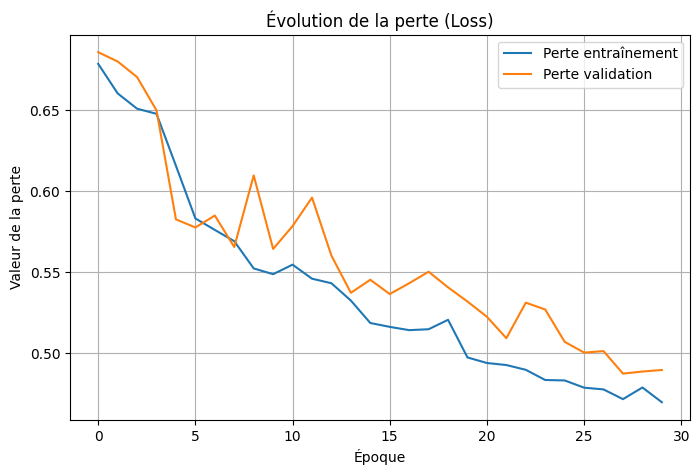

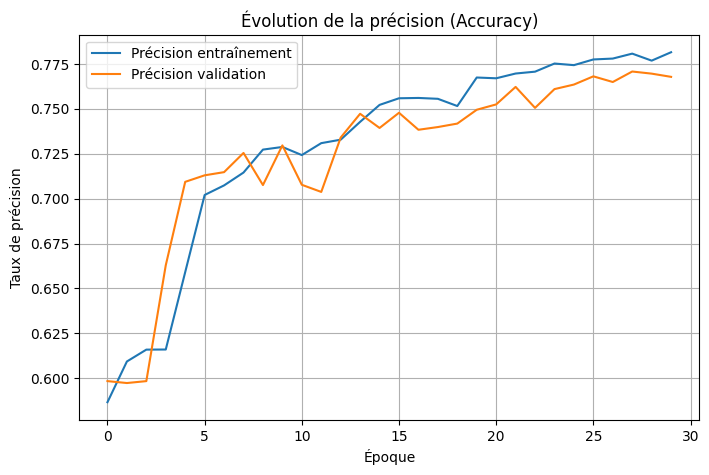

In [28]:
import matplotlib.pyplot as plt

# --- Courbes de perte (Loss) ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['loss'], label='Perte entraînement')
plt.plot(history.history['val_loss'], label='Perte validation')
plt.title("Évolution de la perte (Loss)")
plt.xlabel("Époque")
plt.ylabel("Valeur de la perte")
plt.legend()
plt.grid(True)
plt.show()

# --- Courbes de précision (Accuracy) ---
plt.figure(figsize=(8, 5))
plt.plot(history.history['accuracy'], label='Précision entraînement')
plt.plot(history.history['val_accuracy'], label='Précision validation')
plt.title("Évolution de la précision (Accuracy)")
plt.xlabel("Époque")
plt.ylabel("Taux de précision")
plt.legend()
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


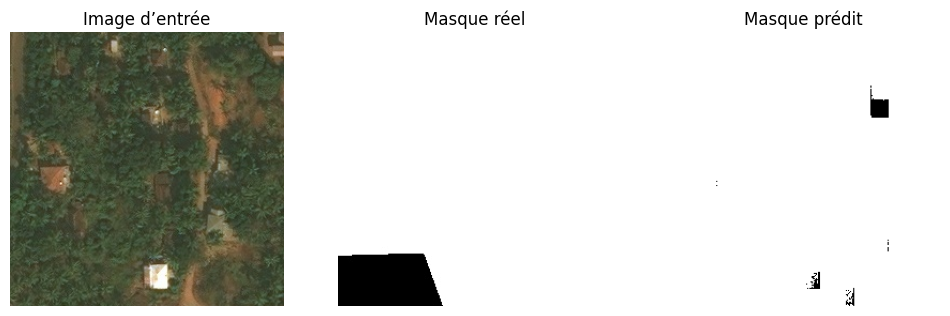

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


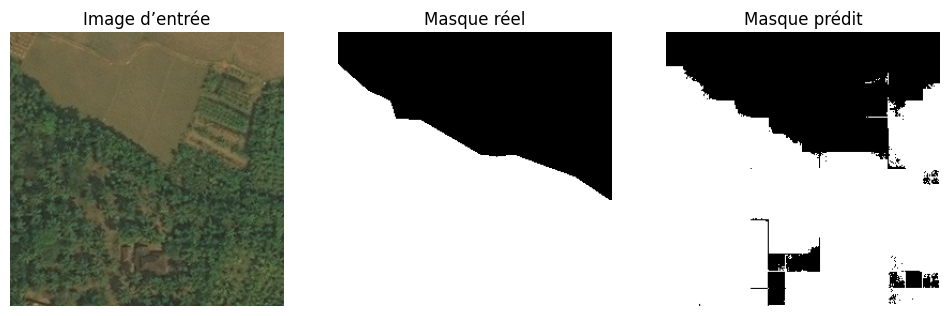

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


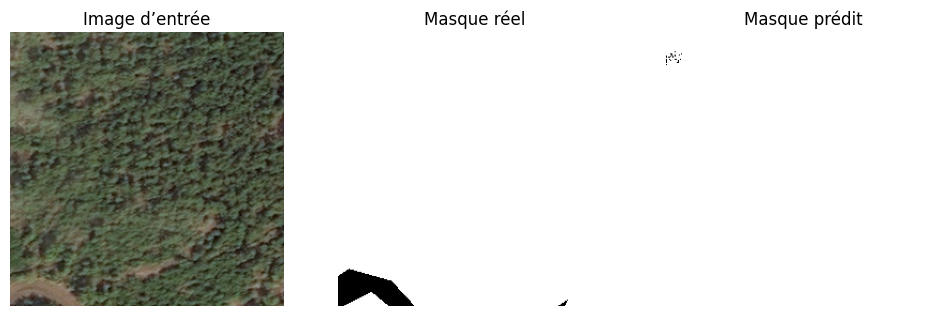

In [29]:
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# --- Fonction pour prédire et afficher ---
def visualize_predictions(model, image_paths, mask_paths, num_samples=3):
    """
    Affiche quelques images avec leur masque réel et le masque prédit par le modèle.
    """
    for i in range(num_samples):
        # Sélectionner une image et son masque
        img_path = image_paths[i]
        mask_path = mask_paths[i]

        # Charger et prétraiter l’image
        img = np.array(load_img(img_path, target_size=(256, 256))) / 255.0
        mask = np.array(load_img(mask_path, target_size=(256, 256), color_mode="grayscale")) / 255.0

        # Ajouter une dimension batch pour la prédiction
        pred_mask = model.predict(np.expand_dims(img, axis=0))[0]

        # Seuil pour convertir en masque binaire (0 ou 1)
        pred_mask = (pred_mask > 0.5).astype(np.float32)

        # Affichage côte à côte
        plt.figure(figsize=(12, 4))
        plt.subplot(1, 3, 1)
        plt.imshow(img)
        plt.title("Image d’entrée")
        plt.axis("off")

        plt.subplot(1, 3, 2)
        plt.imshow(mask.squeeze(), cmap="gray")
        plt.title("Masque réel")
        plt.axis("off")

        plt.subplot(1, 3, 3)
        plt.imshow(pred_mask.squeeze(), cmap="gray")
        plt.title("Masque prédit")
        plt.axis("off")

        plt.show()

# --- Utilisation avec ton dataset de test ---
visualize_predictions(model, test_img, test_mask, num_samples=3)


In [30]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import precision_score, recall_score

# ==========================
# 🔹 Fonctions de métriques
# ==========================
def iou_metric(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    union = np.sum(y_true_f) + np.sum(y_pred_f) - intersection
    return (intersection + smooth) / (union + smooth)

def dice_coef(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

# ==========================
# 🔹 Évaluation sur le test set
# ==========================
# Récupération du premier batch test
X_test, Y_test = test_gen[0]
Y_pred = model.predict(X_test)
Y_pred_bin = (Y_pred > 0.5).astype(np.float32)

# ==========================
# 🔹 Calcul des métriques
# ==========================
iou = iou_metric(Y_test, Y_pred_bin)
dice = dice_coef(Y_test, Y_pred_bin)
precision = precision_score(Y_test.flatten(), Y_pred_bin.flatten())
recall = recall_score(Y_test.flatten(), Y_pred_bin.flatten())

# Évaluation pour récupérer la loss
eval_result = model.evaluate(X_test, Y_test, verbose=0)
loss_value = eval_result[0] 

# ==========================
# 🔹 Affichage des résultats
# ==========================
print(f"IoU (Intersection over Union): {iou:.4f}")
print(f"Dice Coefficient: {dice:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Loss: {loss_value:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
IoU (Intersection over Union): 0.7539
Dice Coefficient: 0.8597
Precision: 0.8351
Recall: 0.8858
Loss: 0.4178
